In [1]:
!pip install git+https://github.com/vgel/repeng.git
!pip install datasets

  Cloning https://github.com/vgel/repeng.git to /tmp/pip-req-build-1398rwvb
  Running command git clone --filter=blob:none --quiet https://github.com/vgel/repeng.git /tmp/pip-req-build-1398rwvb
  Resolved https://github.com/vgel/repeng.git to commit 96b4e2056d16c7b0e29642c057124e7b2069557f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 244.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 250.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 139.4 MB/s eta 0:00:00
  Created wheel for repeng: filename=repeng-0.4.0-py3-none-any.whl size=13616 sha256=ac23bdd3906bfbc526acd470970470ed84673221c9e99a0ea07cb99b3dc88a7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5aikpava/wheels/5f/a5/91/307b0d23bdb8095135b55ef5011549c5635295eba40d4ab1bc
Successfully built repeng

[notice] A new release of pip is 

In [2]:
import os
import re
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

from repeng import ControlVector, ControlModel, DatasetEntry

# Disable tokenizer parallelism to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
hf_token = ''
os.environ["HF_TOKEN"] = hf_token

# Model configuration
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model and tokenizer
print(f"Loading model {model_name}...")
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token = hf_token).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, token = hf_token)

# Wrap model with ControlModel
control_model = ControlModel(model, list(range(0,28)))

Using device: cuda
Loading model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [7]:
def make_dataset(positive_examples, negative_examples):
    """ Create a dataset for training the control vector """
    dataset = [
        DatasetEntry(f"Question: {pos}\nAnswer:", f"Question: {neg}\nAnswer:")
        for pos, neg in zip(positive_examples, negative_examples)
    ]
    return dataset

# Load dataset
print("Loading reasoning dataset...")
reasoning_data = load_dataset("rb/aime_reasoning", "default")['train'].to_pandas()

# Split data: 900 for training, 10 for validation, rest for testing
train_data = reasoning_data.iloc[:950]
val_data = reasoning_data.iloc[950:]

print(f"Data splits: {len(train_data)} train, {len(val_data)} validation")

# Prepare positive and negative reasoning examples
positive_examples = [item['refined_reasoning'] for _, item in train_data.iterrows()]
negative_examples = [item['reasoning_content'] for _, item in train_data.iterrows()]

# Create dataset
cot_dataset = make_dataset(positive_examples, negative_examples)

# Train the control vector
print("Training CoT behavior control vector...")
cot_behavior_vector = ControlVector.train(control_model, tokenizer, cot_dataset, batch_size=1)

# Save control vector
vector_path = "cot_behavior_vector.pt"
torch.save(cot_behavior_vector, vector_path)
print(f"CoT behavior vector saved to {vector_path}")

# Load control vector
cot_behavior_vector = torch.load(vector_path)

Loading reasoning dataset...
Data splits: 950 train, 59 validation
Training CoT behavior control vector...


100%|██████████| 27/27 [00:06<00:00,  4.31it/s]

CoT behavior vector saved to cot_behavior_vector.pt



/tmp/ipykernel_111/1160630448.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cot_behavior_vector = torch.load(vector_path)


In [8]:
def evaluate_vector_strengths(model, tokenizer, prompts, vector, strengths, device='cuda', max_tokens=8192):
    """Evaluate different steering strengths and return results."""
    results = {}
    
    # Simple logging of available layers
    if hasattr(vector, 'directions'):
        available_layers = list(vector.directions.keys())
        print(f"Vector contains layers: {available_layers}")
    
    from tqdm import tqdm
    
    for strength in strengths:
        print(f"Evaluating steering strength {strength}...")
        
        # Create a new control model with just the available layers
        from repeng import ControlModel
        control_model = ControlModel(model.model, available_layers)
        control_model.set_control(vector, strength)
        
        responses = []
        token_lengths = []
        
        for prompt in tqdm(prompts, desc=f"Processing at strength {strength}"):
            # Generate the response
            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            output = control_model.generate(
                **inputs,
                do_sample=False,
                max_new_tokens=max_tokens,
                repetition_penalty=1.1,
            )
            
            response = tokenizer.decode(output.squeeze(), skip_special_tokens=True)
            responses.append(response)
            token_lengths.append(len(tokenizer.encode(response)))
        
        results[strength] = {
            "responses": responses,
            "mean_length": token_lengths,
            "strength": strength
        }
        
    
    return results
# Prepare validation prompts
val_prompts = [f"Solve: {item['question']}\nAnswer: " for _, item in val_data.iterrows()]

# Evaluate different strengths
steered_results = evaluate_vector_strengths(control_model, tokenizer, val_prompts, cot_behavior_vector, [1.5])
original_results = evaluate_vector_strengths(control_model, tokenizer, val_prompts, cot_behavior_vector, [0.0])

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/repeng/control.py:37: UserWarning: Trying to rewrap a wrapped model! Probably not what you want! Try calling .unwrap first.
  warnings.warn(


Vector contains layers: [27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Evaluating steering strength 1.5...


Processing at strength 1.5:   0%|          | 0/59 [00:00<?, ?it/s]/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Processing at strength 1.5: 100%|██████████| 59/59 [1:38:55<00:00, 100.61s/it]


Vector contains layers: [27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Evaluating steering strength 0.0...


Processing at strength 0.0: 100%|██████████| 59/59 [1:39:40<00:00, 101.37s/it]


In [19]:
original_results[0.0]

{'responses': ["Solve: In $\\bigtriangleup ABC$, $AB = 86$, and $AC = 97$. A circle with center $A$ and radius $AB$ intersects $\\overline{BC}$ at points $B$ and $X$. Moreover $\\overline{BX}$ and $\\overline{CX}$ have integer lengths. What is $BC$?\n\n$\\textbf{(A)} \\ 11 \\qquad  \\textbf{(B)} \\ 28 \\qquad  \\textbf{(C)} \\ 33 \\qquad  \\textbf{(D)} \\ 61 \\qquad  \\textbf{(E)} \\ 72$\nAnswer: 28\nAlright, so I've got this geometry problem here about triangle ABC. Let me try to parse it step by step.\n\nFirst, the given information:\n\n- AB = 86\n- AC = 97\n\nThere's a circle centered at point A with radius AB (which is 86) that intersects side BC at points B and X. So, points B and X are on both the circle and the line segment BC. Additionally, the lengths of segments BX and CX are integers. The question is asking for the length of BC, which is one of the options provided: 11, 28, 33, 61, or 72.\n\nThe answer choices suggest that BC is an integer, which makes sense because BX and C

In [20]:
# Save results
results_df = pd.DataFrame({
    "question": [item['question'] for _, item in val_data.iterrows()],

    "original_response": original_results[0.0]['responses'],
    "original_length": original_results[0.0]['mean_length'],

    "steered_response": steered_results[1.5]['responses'],
    "steered_length": steered_results[1.5]['mean_length'],

})

results_path = "cot_steering_results.csv"
results_df.to_csv(results_path, index=False)
print(f"Results saved to {results_path}")

Results saved to cot_steering_results.csv


In [25]:
results_df['tokens_efficiency'] = (results_df['original_length'] - results_df['steered_length'])*100/results_df['original_length']


In [39]:
len(results_df[results_df['original_length']==results_df['steered_length']])

19

In [41]:
results_df[results_df['original_length']>results_df['steered_length']]['tokens_efficiency']

2     16.560914
5     85.160283
9     85.549272
10    88.295688
14    16.865079
20    29.685157
22    12.435476
23    40.851622
26    85.115886
27    35.075831
28     9.040334
35    16.349600
37    32.243879
38    57.862903
40    26.309897
43    24.207961
45    27.181937
46    64.022629
48    17.627599
49    47.681159
50    10.005028
52    67.026508
53    74.723823
Name: tokens_efficiency, dtype: float64

In [42]:
results_df['tokens_efficiency']

0      -38.838022
6      -53.417015
8      -17.538023
11     -12.162706
12     -81.300635
16    -905.703883
17     -63.190184
18    -285.912882
19     -89.910979
29   -1181.183612
30     -44.242109
31     -65.790522
32     -29.431664
33    -297.955302
41    -457.037534
42     -49.290207
44     -34.134008
Name: tokens_efficiency, dtype: float64

In [44]:
results_df_subset = results_df[results_df['tokens_efficiency']]

question             Let $P_1$, $P_2$, $\dots$, $P_{2n}$ be $2n$ di...
original_response    Solve: Let $P_1$, $P_2$, $\dots$, $P_{2n}$ be ...
original_length                                                    659
steered_response     Solve: Let $P_1$, $P_2$, $\dots$, $P_{2n}$ be ...
steered_length                                                    8443
tokens_efficiency                                         -1181.183612
Name: 29, dtype: object

In [52]:
results_df_subset = results_df[results_df['tokens_efficiency']>-100]

In [64]:
results_df_subset = results_df_subset[results_df_subset['tokens_efficiency']!=0]

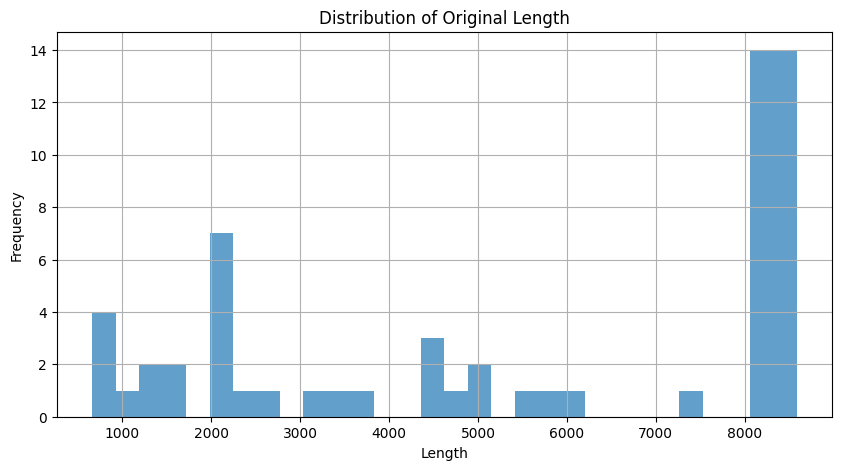

KeyError: 'generated_length'

<Figure size 640x480 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(10, 5))
results_df['original_length'].plot(kind='hist', bins=30, alpha=0.7, title='Distribution of Original Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Original Length')
plt.grid(True)
plt.show()

plt.figure()
results_df['generated_length'].plot(kind='hist', bins=30)
plt.xlabel('Generated Length')
plt.ylabel('Frequency')
plt.title('Distribution of Steered Length')
plt.grid(True)
plt.show()
